In [1]:
from operator import add
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import LombScargle
#from gatspy.periodic import LombScargleFast
from gatspy import periodic
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from multiprocessing import Pool
import numpy as np
from sqlite3 import *
import random
from random import shuffle
from random import randint

In [2]:
conn = connect('minion_1016_sqlite.db')
#conn = connect('astro_lsst_01_1004_sqlite.db')

In [3]:
# LSST zero points  u,g,r,i,z,y
zeroPoints = [0,26.5,28.3,28.13,27.79,27.4,26.58]
FWHMeff = [0.8,0.92,0.87,0.83,0.80,0.78,0.76] # arcmins?
pixelScale = 0.2
readOut = 12.7
sigSys = 0.005
flareperiod = 4096
flarecycles = 10
dayinsec=86400
background = 40
# sat mag u,g,r,i,z,y=14.7,15.7,15.8,15.8,15.3 and 13.9
# start date 59580.033829 end date + 10 years
maglist=[20]*7

In [4]:
def magUncertainy(Filter, objectmag, exposuretime,background, FWHM): # b is background counts per pixel   
    countsPS = 10**((Filter-objectmag)/2.5)
    counts = countsPS * exposuretime
    uncertainty = 1/(counts/((counts/2.3)+(((background/2.3)+(12.7**2))*2.266*((FWHM/0.2)**2)))**0.5) # gain assumed to be 1
    return uncertainty
#from lsst should have got the website! https://smtn-002.lsst.io/

In [5]:
obs = [[59616.299504000002, 59616.373899999999, 59617.377407, 59618.304701000001, 59618.320704999998, 59618.327817999998, 59618.367501000001, 59618.372427000002, 59618.377794, 59618.385405000001, 59620.357216999997, 59620.363462000001, 59620.379584000002, 59620.389000000003, 59621.297327, 59621.305326000002, 59621.314226000002, 59622.312717000001, 59622.366688000002, 59630.275236000001, 59630.286805999996, 59630.303731, 59641.311065000002, 59641.312855999997, 59645.235432000001, 59645.250542000002, 59645.257657000002, 59652.303389000001, 59652.304282999998, 59653.269506999997, 59653.275774000002, 59654.265184999997, 59656.269638999998, 59656.276618000004, 59657.197829999997, 59657.205827999998, 59657.215175999998, 59657.263699000003, 59665.315978999999, 59665.317778999997, 59665.331387999999, 59665.338168000002, 59665.340858000003, 59665.347642000001, 59666.409095000003, 59666.410887999999, 59670.201271999998, 59670.207947000003, 59670.212396000003, 59674.227401999997, 59674.235911999996, 59674.236807000001, 59676.152357999999, 59676.160802999999, 59676.175913999999, 59678.188327000003, 59679.188063000001, 59680.131445999999, 59680.133674999997, 59680.139883000003, 59680.150558000001, 59680.171031999998, 59680.178599999999, 59682.108, 59682.115618999997, 59688.361971999999, 59688.381748, 59693.083102999997, 59693.095993000003, 59693.104443999997, 59695.111334000001, 59695.115773999998, 59695.153166999997, 59695.159857999999, 59695.168356000002, 59695.172381999997, 59696.068472999999, 59696.091596999999, 59696.097387000002, 59696.106288000003, 59696.136084999998, 59697.093621, 59697.098956000002, 59697.106963999999, 59697.122542999998, 59697.130999000001, 59698.07746, 59698.085009000002, 59698.100560999999, 59698.152201999997, 59700.108522000002, 59700.134785000002, 59700.136573999996, 59701.081133, 59701.089132000001, 59702.061070000003, 59702.065957999999, 59702.083315999997, 59703.062193999998, 59703.079078000002, 59703.136494999999, 59703.157184000003, 59703.164822999999, 59704.095727, 59704.168875000003, 59705.400307000004, 59718.252451, 59718.275501999997, 59718.279098999999, 59718.324256, 59720.039016000002, 59720.131756000002, 59722.020894000001, 59722.038672000002, 59724.016089999997, 59724.026761000001, 59724.114585000003, 59725.013185000003, 59725.021194000001, 59725.029653999998, 59725.034094000002, 59725.041222, 59725.994381999997, 59725.998256999999, 59727.988340000004, 59728.030495999999, 59728.033172000003, 59728.989365000001, 59729.002269999997, 59729.009832000003, 59729.010720999999, 59748.116349999997, 59750.009051000001, 59750.016649999998, 59750.01844, 59750.133191000001, 59750.138593999996, 59750.151811999996, 59750.189723000003, 59750.196898000002, 59750.255781, 59751.009136000001, 59752.999348999998, 59757.169065000002, 59757.172694000001, 59757.180769999999, 59757.194269, 59757.991382, 59758.000322, 59758.002114000003, 59758.007490000004, 59758.011968999999, 59758.016893, 59758.982513000003, 59761.330683, 59761.337788999997, 59761.348432999999, 59762.982685000003, 59762.998347000001, 59763.044794000001, 59777.060711999999, 59777.091758000002, 59777.097652999997, 59777.14069, 59781.102318999998, 59781.108595999998, 59781.110858, 59781.115806000002, 59781.181435999999, 59781.191747999997, 59781.224978999999, 59784.020849, 59784.196575000002, 59784.226672999997, 59785.116557000001, 59786.007049, 59786.015151, 59786.028699000002, 59786.043646999999, 59786.209666000002], [59641.311065000002, 59641.312855999997, 59645.235432000001, 59645.250542000002, 59645.257657000002, 59670.201271999998, 59670.207947000003, 59670.212396000003, 59697.093621, 59697.098956000002, 59697.106963999999, 59697.122542999998, 59697.130999000001, 59700.108522000002, 59700.134785000002, 59700.136573999996, 59702.061070000003, 59702.065957999999, 59702.083315999997, 59703.062193999998, 59703.079078000002, 59703.136494999999, 59703.157184000003, 59703.164822999999, 59728.030495999999, 59728.033172000003, 59762.982685000003, 59762.998347000001, 59763.044794000001, 59785.116557000001], [59665.315978999999, 59665.317778999997, 59665.331387999999, 59665.338168000002, 59665.340858000003, 59665.347642000001, 59751.009136000001, 59752.999348999998, 59757.991382, 59758.000322, 59758.002114000003, 59758.007490000004, 59758.011968999999, 59758.016893, 59758.982513000003, 59761.330683, 59761.337788999997, 59761.348432999999, 59781.102318999998, 59781.108595999998, 59781.110858, 59781.115806000002, 59781.181435999999, 59781.191747999997, 59781.224978999999, 59786.007049, 59786.015151, 59786.028699000002, 59786.043646999999, 59786.209666000002], [59695.111334000001, 59695.115773999998, 59695.153166999997, 59695.159857999999, 59695.168356000002, 59695.172381999997, 59701.081133, 59701.089132000001, 59720.039016000002, 59720.131756000002, 59750.009051000001, 59750.016649999998, 59750.01844, 59750.133191000001, 59750.138593999996, 59750.151811999996, 59750.189723000003, 59750.196898000002, 59750.255781, 59757.169065000002, 59757.172694000001, 59757.180769999999, 59757.194269, 59777.060711999999, 59777.091758000002, 59777.097652999997, 59777.14069, 59784.020849, 59784.196575000002, 59784.226672999997], [59616.299504000002, 59674.227401999997, 59674.235911999996, 59674.236807000001, 59676.152357999999, 59676.160802999999, 59676.175913999999, 59680.131445999999, 59680.133674999997, 59680.139883000003, 59680.150558000001, 59680.171031999998, 59680.178599999999, 59693.083102999997, 59693.095993000003, 59693.104443999997, 59696.068472999999, 59696.091596999999, 59696.097387000002, 59696.106288000003, 59696.136084999998, 59698.07746, 59698.085009000002, 59698.100560999999, 59698.152201999997, 59728.989365000001, 59729.002269999997, 59729.009832000003, 59729.010720999999, 59748.116349999997], [59656.269638999998, 59656.276618000004, 59657.197829999997, 59657.205827999998, 59657.215175999998, 59657.263699000003, 59678.188327000003, 59679.188063000001, 59688.361971999999, 59688.381748, 59704.095727, 59704.168875000003, 59705.400307000004, 59718.252451, 59718.275501999997, 59718.279098999999, 59718.324256, 59722.020894000001, 59722.038672000002, 59724.016089999997, 59724.026761000001, 59724.114585000003, 59725.013185000003, 59725.021194000001, 59725.029653999998, 59725.034094000002, 59725.041222, 59725.994381999997, 59725.998256999999, 59727.988340000004], [59616.373899999999, 59617.377407, 59618.304701000001, 59618.320704999998, 59618.327817999998, 59618.367501000001, 59618.372427000002, 59618.377794, 59618.385405000001, 59620.357216999997, 59620.363462000001, 59620.379584000002, 59620.389000000003, 59621.297327, 59621.305326000002, 59621.314226000002, 59622.312717000001, 59622.366688000002, 59630.275236000001, 59630.286805999996, 59630.303731, 59652.303389000001, 59652.304282999998, 59653.269506999997, 59653.275774000002, 59654.265184999997, 59666.409095000003, 59666.410887999999, 59682.108, 59682.115618999997]]

In [6]:
def averageFlux(observations, Frequency, exptime):
    b = [0]*len(observations)
    for seconds in range(0, exptime):
        a = [np.sin((2*np.pi*(Frequency))*(x+(seconds/(3600*24)))) for x in observations] # optical modulation
        b = map(add, a, b)
    c = [z/exptime for z in b]
    return c

def Flux(observations,Frequency,exptime):
    a = [np.sin((2*np.pi*(Frequency)*x)) for x in observations]
    return a

In [7]:
def ellipsoidalFlux(observations, Frequency,exptime):
    period = 1/(Frequency)
    phase = [(x % (2*period)) for x in observations]
    b = [0]*len(observations)
    for seconds in range(0, exptime):
        a = [np.sin((2*np.pi*(Frequency))*(x+(seconds/(3600*24)))) for x in observations] # optical modulation
        b = map(add, a, b)
    c = [z/exptime for z in b]
    
    for x in range(0,len(phase)):
        if (phase[x]+(0.5*period)) < period:
            c[x] = c[x]*0.5
        else:
            c[x] = c[x]*1
    return c
## this is doing something but not the right something, come back to it 

In [8]:
def flaring(B, length, dayinsec=86400,amplitude=1):   
    global flareMag, minutes
    fouriers = np.linspace(0.00001,0.05,(dayinsec/30))
    logF = [np.log(x) for x in fouriers] # start at 30 go to a day in 30 sec increments
    real = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers] #random.gauss(mu,sigma) to change for values from zurita
    # imaginary = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers]
    IFT = np.fft.ifft(real)
    seconds = np.linspace(0,dayinsec, (dayinsec/30)) # the day in 30 sec increments
    minutes = [x for x in seconds]
    minimum = (np.max(-IFT))
    positive = [x + minimum for x in IFT] # what did this even achieve? it helped with normalisation!
    normalised = [x/(np.mean(positive)) for x in positive] # find normalisation
    normalisedmin = minimum/(np.mean(positive))
    normalised = [x - normalisedmin for x in normalised]
    flareMag = [amplitude * x for x in normalised] # normalise to amplitude
    logmins = [np.log(d) for d in minutes] # for plotting?
#     plt.plot(minutes,flareMag)
#     plt.title('lightcurve')
#     plt.show()
    return flareMag

In [ ]:
def lombScargle(frequencyRange,objectmag=maglist,loopNo=1,df=0.001,fmin=0.001,numsteps=100,modulationAmplitude=0.1,Nquist=200): # frequency range and object mag in list
    global totperiod, totmperiod, totpower, date, amplitude, frequency, periods, LSperiod, power, mag, error, SigLevel
    totperiod = []
    totmperiod = []
    totpower = [] # reset
    SigLevel = []
    filterletter = ['o','u','g','r','i','z','y']
    for frange in range(0, 1):len(frequencyRange)):
        period = 1/(frequencyRange)
        if period > 0.1:
            numsteps = 10000
        elif period > 0.01:
            numsteps = 75000
        else:
            numsteps = 100000
        freqs = fmin + df * np.arange(numsteps) # for manuel
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset
        measuredpower = [] # reset
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            #y[z] = averageFlux(obs[z], frequencyRange[frange], 30)  # amplitde calculation for observations, anf frequency range
            y[z] = ellipsoidalFlux(obs[z], frequencyRange,30)
            y[z] = [modulationAmplitude * t for t in y[z]] # scaling
            for G in range(0, len(y[z])):
                flareMinute = int(round((obs[z][G]*24*60*2)%((dayinsec/(30*2))*flarecycles)))
                y[z][G] = y[z][G] + longflare[flareMinute] # add flares swapped to second but not changing the name intrtoduces fewer bugs
        date = []
        amplitude = []
        mag = []
        error = []
        filts = []
        for z in range(1, len(y)):
            #date.extend([x for x in obs[z]])
            date.extend(obs[z])
            amplitude = [t + random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise
            print(amplitude)
            print(objectmag[z])
            mag.extend([objectmag[z] - t for t in amplitude]) # add actual mag
            error.extend([sigSys + magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(amplitude))
            filts.extend([filterletter[z]]*len(amplitude))


        plt.plot(date, mag, 'o')
        #plt.xlim(lower,higher)
        plt.xlabel('time (days)')
        plt.ylabel('mag')
        plt.gca().invert_yaxis()
        plt.show()

        model = periodic.LombScargleMultibandFast(fit_period=False)
        model.fit(date, mag, error, filts)
        power = model.score_frequency_grid(fmin, df, numsteps) 
        
        if period > 10.:
            model.optimizer.period_range=(10, 110)
        elif period > 0.51:
            model.optimizer.period_range=(0.5, 10)
        elif period > 0.011:
            model.optimizer.period_range=(0.01, 0.52)
        else:
            model.optimizer.period_range=(0.0029, 0.012)
        
        LSperiod = model.best_period

        fig, ax = plt.subplots()
        ax.plot(1./freqs, power)
        ax.set(xlim=(0, 10), ylim=(0, 1.2),
               xlabel='period (days)',
               ylabel='Lomb-Scargle Power');
        plt.show()

        
        phase = [(day % (period*2))/(period*2) for day in date]
        #idealphase = [(day % (period*2))/(period*2) for day in dayZ]
        #print(len(phase),len(idealphase))
        #plt.plot(idealphase,Zmag,'ko',)
        plt.plot(phase, mag, 'o', markersize=4)
        plt.xlabel('Phase')
        plt.ylabel('Magnitude')
        plt.gca().invert_yaxis()
        plt.show()

#         print('actualperiod', period, 'measured period', np.mean(LSperiod),power.max())# 'power',np.mean(power[maxpos]))
#         print(frequencyRange[frange], 'z', z)

        totperiod.append(period)
        totmperiod.append(np.mean(LSperiod))
        totpower.append(power.max())

        measuredpower.append(power.max())
        maxpower = []           
        counter = 0.
        for loop in range(0,loopNo):
            random.shuffle(date)
            model = periodic.LombScargleMultibandFast(fit_period=False)
            model.fit(date, mag, error, filts)
            power = model.score_frequency_grid(fmin, df, numsteps)  
            maxpower.append(power.max())


        for X in range(0, len(maxpower)):
            if maxpower[X] > measuredpower[-1]:
                counter = counter + 1. 
        Significance = (1.-(counter/len(maxpower)))
        #print('sig', Significance, 'counter', counter)
        SigLevel.append(Significance)


In [11]:
#findObservations([(630,)])
#remove25(obs)
#averageFlux(obs[0], 1, 30)
longflare = []
for floop in range(0,flarecycles):
    flareone = flaring(-1, flareperiod, amplitude=0.3)
    flareone = flareone[0:1440]
    positiveflare = [abs(x) for x in flareone]
    longflare.extend(positiveflare)
    


/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [12]:
PrangeLoop = np.logspace(-2.5,2,10)
FrangeLoop = [(1/x) for x in PrangeLoop]


In [22]:
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []

MagRange = np.linspace(17,24,50)
for h in range(0,len(MagRange)):
    lombScargle(FrangeLoop,([MagRange[h]]*7),loopNo=10000)
    fullmeasuredPeriod.append(totmperiod)
    fullPeriod.append(totperiod)
    fullPower.append(totpower)
    fullSigLevel.append(SigLevel)
    fullMag.append([MagRange[h]]*len(FrangeLoop))



Finding optimal frequency:
 - Estimated peak width = 0.037
 - Using 5 steps per peak; omega_step = 0.0074
 - User-specified period range:  0.5 to 10
 - Computing periods at 1616 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
('sig', 1.0, 'counter', 0.0)
Finding optimal frequency:
 - Estimated peak width = 0.037
 - Using 5 steps per peak; omega_step = 0.0074
 - User-specified period range:  0.5 to 10
 - Computing periods at 1616 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
('sig', 1.0, 'counter', 0.0)
Finding optimal frequency:
 - Estimated peak width = 0.037
 - Using 5 steps per peak; omega_step = 0.0074
 - User-specified period range:  0.5 to 10
 - Computing periods at 1616 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
('sig', 1.0, 'counter', 0.0)
Finding optimal frequency:
 - Estimated peak width = 0.037
 - Using 5 steps per peak; omega_step = 0.0074
 - User-specified period range:  0.5 to 10
 - Computin

KeyboardInterrupt: 

[0.09156984625511122, 0.080316309299048066, 0.035918142389678095, 0.12247770728465021, 0.04407472540239158, 0.23115556504388535, 0.17549951950746728, 0.036394966569969919, 0.24633145607587431, 0.21835814921995764, 0.087457470384627561, 0.00084046446640521563, 0.16304261979804377, 0.1037574189467253, 0.12428474259487057, -0.039779612518952595, 0.10706328414694091, 0.04792086439632285, 0.084563456068989018, 0.23463651120651993, 0.16459649823210268, 0.048881151723189811, 0.06626110747486702, 0.18128381456983067, 0.03761849314708747, 0.17284582124146622, 0.080029484013704438, 0.20104023819611821, 0.15864011253910076, 0.0047898320695642232]
20
[0.066546991612996875, 0.27345043671392533, 0.14606808654266137, 0.011559200077923305, 0.12674014776222609, 0.11657883063605311, 0.25735888890456216, 0.10093737969745224, 0.11813943790961584, 0.084476584314435707, 0.12161435747175463, 0.23755647013788381, 0.011557123854909455, 0.16899169734118469, 0.10079436317518721, 0.081207216306031588, 0.217093756

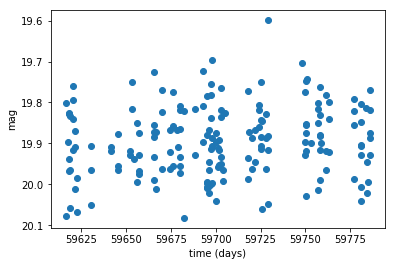

/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Finding optimal frequency:
 - Estimated peak width = 0.037
 - Using 5 steps per peak; omega_step = 0.0074
 - User-specified period range:  0.0029 to 0.012
 - Computing periods at 222154 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


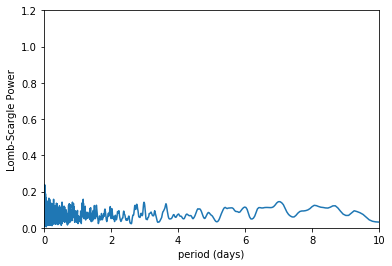

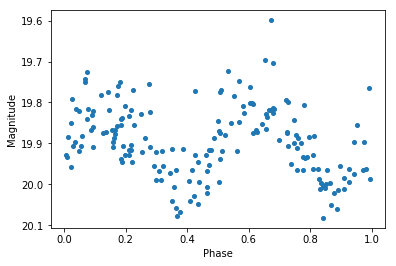

[0.19183373625135913, 0.128032608165291, 0.031296519332431695, 0.10182607245584396, -0.029468032006526583, 0.24736198960268635, 0.10343781699847446, 0.16876374573493799, 0.35215304012540127, 0.11418263886221458, 0.093375363994286115, 0.13103157140913774, 0.17837065639710609, 0.063868600012069482, 0.085463327525061666, -0.051091207282661165, 0.10113677987556371, 0.023968819653615758, 0.12934731826256857, 0.30505674823870871, 0.015408688766339079, -0.040109041284938092, -0.017802760716691689, 0.15999364787005455, 0.15070936326097253, 0.25960737646182197, 0.11708916795938493, 0.10376022376556097, 0.13280420945084467, 0.010255977466609511]
20
[0.050877163262729591, 0.14493284224793307, 0.20967710724669833, -0.027290478861410207, 0.11483147413735055, 0.071328366852205241, 0.16524642152721819, 0.065123137200091122, 0.15681228751023898, 0.13457402320825582, 0.18156422481683102, 0.043353630490811576, 0.18269933324903115, 0.034111473527626134, 0.17972736936081907, 0.093275377637888776, 0.081570

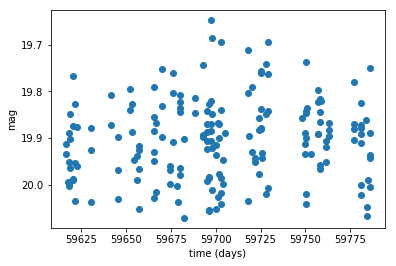

Finding optimal frequency:
 - Estimated peak width = 0.037
 - Using 5 steps per peak; omega_step = 0.0074
 - User-specified period range:  0.0029 to 0.012
 - Computing periods at 222154 steps


Process PoolWorker-6:
Process PoolWorker-8:
Process PoolWorker-4:
Process PoolWorker-5:
Process PoolWorker-3:
Process PoolWorker-2:
Process PoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootst

  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.

Process PoolWorker-30:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-26:
Traceback (most recent call last):
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootst

  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    racquire()
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
KeyboardInterrupt
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
    racquire()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
KeyboardInterrupt
    racquire()
    racquire()
KeyboardInterrupt
  File 

    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
    racquire()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
    self.run()
    racquire()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
KeyboardInterrupt
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiproc

    racquire()
KeyboardInterrupt
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
    self.run()
    racquire()
KeyboardInterrupt
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    racquire()
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
KeyboardInterrupt
Process PoolWorker-73:
Process PoolWorker-67:
Process PoolWorker-70:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-69:
Process PoolWorker-68:
Process PoolWorker-74:
Process PoolWorker-71:
Process PoolWorker-72:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mj1e

  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    racquire()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
    racquire()
    task = get()
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/pyth

  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2

  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self.run()
    self.run()
    self._target(*self._args, **self._kwargs)
  F

    racquire()
    racquire()
KeyboardInterrupt
    racquire()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
    racquire()
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
    racquire()
KeyboardInterrupt
    racquire()
KeyboardInterrupt
Process PoolWorker-121:
Process PoolWorker-122:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multip

    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get(

  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
KeyboardInterrupt
Process PoolWorker-152:
Process PoolWorker-154:
Process PoolWorker-153:
Process PoolWorker-150:
Process PoolWorker-148:
Process PoolWorker-151:
Traceback (most recent call last):
Process PoolWorker-149:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _boo

  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
    racquire()
    task = get()
    racquire()
    task = get()
KeyboardInterrupt
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
    racquire()
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    racquire()
KeyboardInterrupt
KeyboardInterrupt
    racquire()
KeyboardInterrupt
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/mj

KeyboardInterrupt
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    racquire()
KeyboardInterrupt
    self._target(*self._args, **self._kwargs)
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
KeyboardInterrupt
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    

  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/mi

Traceback (most recent call last):
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self.run()
    self.run()
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
 

    task = get()
    task = get()
    racquire()
KeyboardInterrupt
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
    racquire()
KeyboardInterrupt
    racquire()
    racquire()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
    racquire()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
KeyboardInterrupt
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/home/mj1e16/miniconda2

    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    task = get()
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = 

    racquire()
KeyboardInterrupt
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    racquire()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
    racquire()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
Process PoolWorker-247:
Process PoolWorker-246:
Process PoolWorker-245:
Process PoolWorker-244:
Process PoolWorker-249:
Traceback (most recent call last):
Process PoolWorker-243:
Process PoolWorker-250:
Process PoolWorker-248:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mj1e16

  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
KeyboardInterrupt
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
KeyboardInterrupt
Process PoolWorker-257:
Process PoolWorker-258:
Process PoolWorker-261:
Traceback (most recent call last):
Process PoolWorker-262:
Process PoolWorker-256:
Process PoolWorker-259:
Traceback (most recent call last):
Process PoolWorker-263:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call l

  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    racquire()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
    task = get()
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
KeyboardInterrupt
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    racquire()
    racqu

  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7

    self._target(*self._args, **self._kwargs)
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    task = get()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
    task = get()
    

    racquire()
    racquire()
    racquire()
KeyboardInterrupt
KeyboardInterrupt


In [ ]:
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []
maglist = [20]*7
MagRange = np.linspace(17,24,50)
pool = Pool(8)
for h in range(0,len(MagRange)):
    maglist = [MagRange[h]]*7
    pool.map(lombScargle,[FrangeLoop])
    fullmeasuredPeriod.append(totmperiod)
    fullPeriod.append(totperiod)
    fullPower.append(totpower)
    fullSigLevel.append(SigLevel)
    fullMag.append([MagRange[h]]*len(FrangeLoop))



In [95]:
for y in range(0,len(MagRange)):
    for z in range(0, len(FrangeLoop)):
        if fullmeasuredPeriod[y][z] < (fullPeriod[y][z]+(fullPeriod[y][z]*0.05)) and fullmeasuredPeriod[y][z] > (fullPeriod[y][z]-(fullPeriod[y][z]*0.05)):
            donothing = 0 
        else: 
            fullSigLevel[y][z] = 0


In [ ]:
File = open('minionfullmeasuredPeriodFile.txt','w')
File.write(str(fullmeasuredPeriod))
File.close() 
File = open('minionfullPeriodFile.txt','w')
File.write(str(fullPeriod))
File.close() 
File = open('minionfullPowerFile.txt','w')
File.write(str(fullPower))
File.close() 
File = open('minionfullSigLevelFile.txt','w')
File.write(str(fullSigLevel))
File.close() 
File = open('minionfullMagFile.txt','w')
File.write(str(fullMag))
File.close() 